In this lesson, we are adding more components into the original phugoid motion analysis

In [1]:
# we must load modules and libraries that we need for this problem

In [2]:
import math
import numpy
from matplotlib import pyplot
%matplotlib inline

In [3]:
#now, we have to globally set font family and size for all plots
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [4]:
# set parameters and constants for this lesson
g = 9.81 # gravity
vt = 30.0 #trim velocity
CD = 1.0 / 40 # drag coefficient
CL = 1.0 # lift coefficient

# initial conditions
v0 = vt #begin at trim velocity
theta0 = 0.0 #starting trajectory angle
x0 = 0.0 # starting horizontal position
y0 = 1000.0 #starting altitude

now, we must create a function that matches the full differential system in vector form. 

In [5]:
def rhs_phugoid(u, CL, CD, g, vt):
    v, theta, x, y = u
    rhs = numpy.array([-g*math.sin(theta) - CD / CL * g / vt**2 * v**2, # this comes from the original equation for v
                      -g * math.cos(theta) / v + g / vt**2 *v, #this is equation for theta from equation 15
                      v * math.cos(theta), #this is the equation for x position in equation 15
                      v * math.sin(theta)]) # this is equation for y position in equation 15
    return rhs
                       

In [6]:
# now we can simply apply euler's method with a simple function shown before
def euler_step(u, f, dt, *args):
    u_new = u +dt * f(u, *args)
    return u_new


In [8]:
T = 100.0 #length of time interval
dt = 0.1 #time-step size
N = int(T / dt) +1 # number of time steps

#this array stores the solution at each time step
u = numpy.empty((N, 4))
#initial condition set as above
u[0] = numpy.array([v0, theta0, x0, y0])

#using euler's method to intigrate:

for n in range(N-1):
    u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)

In [9]:
# find glider position over time
x = u[:, 2]
y = u[:, 3]

Now we can plot the path of the glider

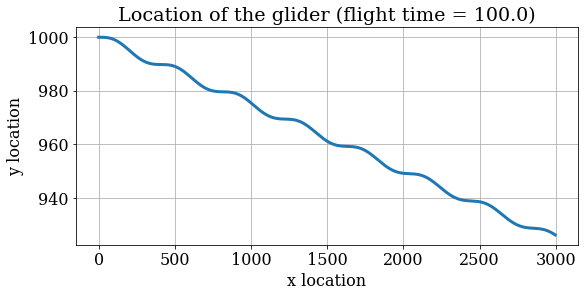

In [11]:
pyplot.figure(figsize=(9.0, 4.0))
pyplot.title('Location of the glider (flight time = {})'.format(T))
pyplot.xlabel('x location')
pyplot.ylabel('y location')
pyplot.grid()
pyplot.plot(x, y, color ='C0', linestyle = '-', linewidth=3)

now, we have to use grid convergence of euler's method for the phugoid model to find the convergence of this model

In [12]:
# set list of time steps to be used as dt
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

#create an empty list that is going to be filled with solutions of each time step
u_values = []

for dt in dt_values:
    N = int(T / dt) +1 # total number of time steps
    #this next array will store solutions at each time step
    u = numpy.empty((N, 4))
    #set initial conditions as above
    u[0] = numpy.array([v0, theta0, x0, y0])
    #integrate using euler's method
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
        # store solutions for present time-step size
    u_values.append(u)

now, we have to compare the coarser time steps to finer time steps. but, there are more solutions for the timesteps with smaller values. So, we must slice an array to grab subset values from them.

create a function that compares the coarser grid to the finest grid, or smallest step size

In [15]:
def l1_diff(u_coarse, u_fine, dt):
    N_coarse = len(u_coarse)
    N_fine = len(u_fine)
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt* numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

In [18]:
#this line creates an empty list to store the difference in the solution
# between two consecutive grids.
diff_values = []

for i, dt in enumerate(dt_values[:-1]):
    diff = l1_diff(u_values[i][:, 2], u_values[-1][:,2], dt)
    diff_values.append(diff)

now, we have to create a plot of the resulted difference between the two results. we use a log-log plot using loglog().

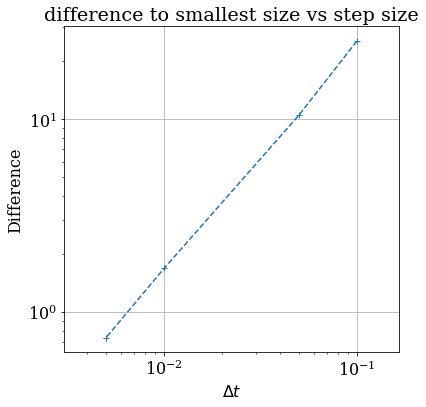

In [21]:
#plotting difference vs. time step size
pyplot.figure(figsize=(6.0, 6.))
pyplot.title('difference to smallest size vs step size')
pyplot.xlabel('$\Delta t$') #x-axis label
pyplot.ylabel('Difference') # y-axis label
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values,
             color='C0', linestyle='--', marker='+') #create log-log plot
pyplot.axis('equal'); #makes the axes scaled equally

now, we can use analitical solutions to find the order of convergence, the code below does this

In [23]:
r = 2 # refinement ratio for the time-step size
h = 0.001 # base grid size

dt_values2 = [h, r*h, r**2 * h]
u_values2 = []

for dt in dt_values2:
    N = int(T / dt) + 1 # number of time steps
    u = numpy.empty((N, 4))
    #set initial conditions as above
    u[0] = numpy.array([v0, theta0, x0, y0])
    #integrate using euler's method
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
        # store solutions for present time-step size
    u_values.append(u)
    
# calculate f2 - f1
f2_f1 = l1_diff(u_values2[1][:, 2], u_values2[0][:, 2], dt_values2[1])
# find f3 - f2
f3_f2 = l1_diff(u_values2[2][:, 2], u_values2[1][:, 2], dt_values2[2])

#find observed order of convergence.

p = math.log(f3_f2 / f2_f1) / math.log(r)
print('Observed order of convergence: Order = {:.3f}' .format(p))

IndexError: list index out of range